418 626


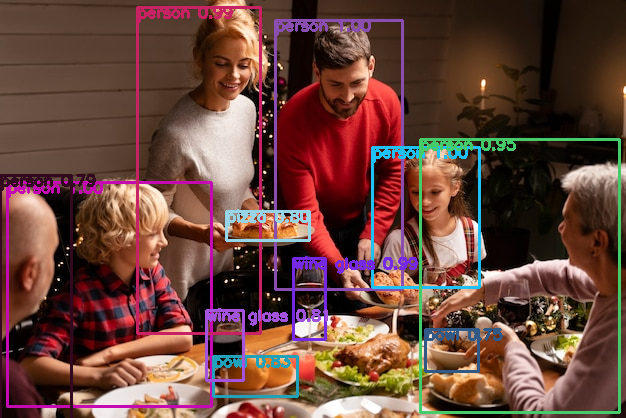

In [1]:
import cv2
import numpy as np
import requests
import platform
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont

weights_path = "yolov3/yolov3.weights"
config_path = "yolov3/yolov3.cfg"
names_path = "yolov3/coco.names"

def random_color() :
  import random
  return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 

def get_font() :
  import platform
  font_size = 20
  try:
      if platform.system() == "Windows":
          # 윈도우: 맑은 고딕
          return ImageFont.truetype("malgun.ttf", font_size)
      elif platform.system() == "Darwin":  # macOS
          # 맥: 애플 고딕
          return ImageFont.truetype("AppleGothic.ttf", font_size)
      else:  # Linux 등
          # 기본 폰트 (한글 지원 안 될 수 있음)
          return ImageFont.load_default(size=font_size)
  except IOError:
      # 지정한 폰트 파일이 없을 경우 PIL 기본 폰트 사용
      return ImageFont.load_default()


with open(names_path, "r", encoding="utf-8") as coco_file :
    label_list = coco_file.read().strip().split('\n')

net = cv2.dnn.readNet(weights_path, config_path)

TEST_IMAGE_URL = "https://img.freepik.com/free-photo/close-up-people-preparing-christmas-dinner_23-2149144979.jpg"
response = requests.get(TEST_IMAGE_URL)
image_data = response.content
image_np = np.frombuffer(image_data, np.uint8)
image_array = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
image_height, image_width = image_array.shape[:2]
print(image_height, image_width)

blob = cv2.dnn.blobFromImage(image_array, 1/255.0, (416, 416), swapRB=True, crop=False)

net.setInput(blob)

out_layer_list = net.getUnconnectedOutLayersNames()
detection_list = net.forward(out_layer_list)

bounding_box_list = list()
confidence_list = list()
label_index_list = list()

for prediction_list in detection_list :
    color = random_color()

    for prediction in prediction_list :
        bounding_box = prediction[:4] * np.array([image_width, image_height, image_width, image_height])
        center_x, center_y, w, h = bounding_box.astype('int')
        label_score_list = prediction[5:]

        x = int(center_x - w/2)
        y = int(center_y - h/2)

        label_index = np.argmax(label_score_list)
        confidence = label_score_list[label_index]

        if confidence > 0 :
            bounding_box_list.append([x, y, w ,h])
            confidence_list.append(confidence)
            label_index_list.append(label_index)


# print(len(bounding_box_list), len(confidence_list), len(label_index_list))

extracted_index_list = cv2.dnn.NMSBoxes(bounding_box_list, confidence_list, 0.7, 0.3)
extracted_index_list

for extracted_index in extracted_index_list :
    color = random_color()
    x, y, w, h = bounding_box_list[extracted_index]
    confidence = confidence_list[extracted_index]
    label_index = label_index_list[extracted_index]
    label_text = label_list[label_index]

    cv2.rectangle(image_array, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image_array, f"{label_text} {confidence:.2f}", (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
# print(image_array)
Image.fromarray(image_array)
# Image.open(BytesIO(image_data))